# Preprocessing

## Importing

In [1]:
%matplotlib qt
import mne
import matplotlib.pyplot as plt
import numpy as np
import os.path as op
mne.__version__
mne.set_log_level("WARNING")


## Define path and loading data

In [ ]:
file_name='IR_01_Pilot_a.bdf'
file_folder='/Users/dannem/Documents/Ilya_study/Data'
fname = op.join(file_folder,file_name)
raw_1 = mne.io.read_raw_edf(fname,preload=True) # preload=True to really load the file
picks = mne.pick_types(raw.info, eeg=True, exclude='bads')

'''
file_name=file_name[:-4]
file_folder='/Users/dannem/Documents/Ilya_study/Analysis'
print(fname)
'''

## Setting the montage

In [4]:
fname=file_folder+'/'+file_name+'_raw.fif'
montage = mne.channels.read_montage("standard_1020")
raw.set_montage(montage)
raw.save(fname,overwrite=True)

## Filtering

In [5]:
fname=fname[:-8]+'_flt_raw.fif'

In [ ]:
raw.notch_filter(np.arange(60, 181, 60))  # Notch
raw.save(fname,overwrite=True)

In [6]:
raw.filter(0.1, 40., fir_design='firwin')
raw.save(fname,overwrite=True)

In [ ]:
raw.filter(1, 40, method='iir')

## Re-referencing

In [7]:
raw.set_eeg_reference("average")
raw.save(fname,overwrite=True)

## Checking events

In [13]:
events = mne.find_events(raw, initial_event=True, consecutive=True, shortest_event=1)
#plt.plot(raw._data[-1])
np.unique(events[:,2])

array([    1,     2,     4,     5,     7,     8,    10,    11,    13,
          14,    26,    32,    35,    88,    99,   101,   102,   103,
         104,   105,   106,   107,   108,   109,   110,   111,   112,
         113,   114,   115,   116,   117,   118,   119,   120,   121,
         122,   123,   124,   125,   126,   127,   128,   129,   130,
         131,   132,   133,   134,   135,   136,   137,   138,   139,
         140,   141,   142,   143,   144,   145,   146,   147,   148,
         149,   150,   151,   152,   153,   154,   198,   201,   202,
         203,   204,   205,   206,   207,   208,   209,   210,   211,
         212,   213,   214,   215,   216,   217,   218,   219,   220,
         221,   222,   223,   224,   225,   226,   227,   228,   229,
         230,   231,   232,   233,   234,   235,   236,   237,   238,
         239,   240,   241,   242,   243,   244,   245,   246,   247,
         248,   249,   250,   251,   252,   253,   254, 65536, 65559,
       65562, 65565,

## Reading epochs

In [30]:
trigs=list(range(101, 151))+list(range(201, 251))
event_ids={str(x):x for x in trigs}
epochs = mne.Epochs(raw, events, event_ids, -0.1, 1.8, picks=picks,
                baseline=None, preload=True)
print(event_ids)

{'101': 101, '102': 102, '103': 103, '104': 104, '105': 105, '106': 106, '107': 107, '108': 108, '109': 109, '110': 110, '111': 111, '112': 112, '113': 113, '114': 114, '115': 115, '116': 116, '117': 117, '118': 118, '119': 119, '120': 120, '121': 121, '122': 122, '123': 123, '124': 124, '125': 125, '126': 126, '127': 127, '128': 128, '129': 129, '130': 130, '131': 131, '132': 132, '133': 133, '134': 134, '135': 135, '136': 136, '137': 137, '138': 138, '139': 139, '140': 140, '141': 141, '142': 142, '143': 143, '144': 144, '145': 145, '146': 146, '147': 147, '148': 148, '149': 149, '150': 150, '201': 201, '202': 202, '203': 203, '204': 204, '205': 205, '206': 206, '207': 207, '208': 208, '209': 209, '210': 210, '211': 211, '212': 212, '213': 213, '214': 214, '215': 215, '216': 216, '217': 217, '218': 218, '219': 219, '220': 220, '221': 221, '222': 222, '223': 223, '224': 224, '225': 225, '226': 226, '227': 227, '228': 228, '229': 229, '230': 230, '231': 231, '232': 232, '233': 233, '23

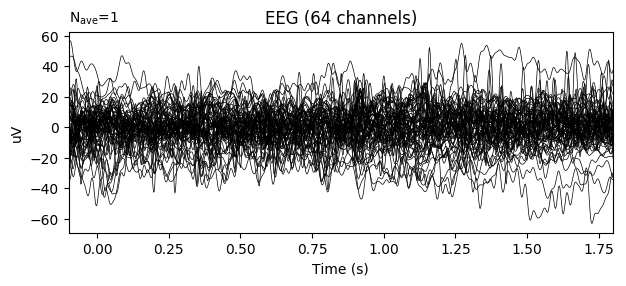

In [34]:
epochs['120'].average().plot()
epochs.average().plot_topo(background_color='w')

In [35]:
epochs_data = epochs['101'].get_data()
print(epochs_data.shape)

(1, 64, 974)


## Inspecting the data

In [ ]:
raw.plot(n_channels=64, scalings={"eeg": 75e-6}, 
         events=events, duration=5, start=10, event_color={1: "green", 2: "blue", 3: "red"})


For annotations press a, for butterfly mode press b on a pop-up window.
To mark the channels as bad press on the name in the pop-up window

In [ ]:
raw.annotations # checking annotated segments

## Blink removal with ICA

In [ ]:
raw_tmp = raw.copy()
raw_tmp.filter(1, None)
ica = mne.preprocessing.ICA(method="extended-infomax", random_state=1)
ica.fit(raw_tmp)

In [ ]:
ica.save('/Users/dannem/Desktop/IR_01_Pilot_ica.fif')
ica.plot_components(inst=raw_tmp)
ica.plot_sources(inst=raw_tmp)

In [ ]:
ica.exclude = [1]
raw_corrected = raw.copy()
ica.apply(raw_corrected)
raw_corrected.plot(n_channels=25, start=54, duration=4,
                   scalings=dict(eeg=250e-6, eog=750e-6))

# Tools

## Saving and loading bad segments and channels

In [ ]:
if raw.annotations is not None:
    onset = np.floor(raw.annotations.onset * raw.info["sfreq"])
    duration = np.ceil(raw.annotations.duration * raw.info["sfreq"])
    segments = np.column_stack([onset, duration]).astype(int)
    np.savetxt("S001R04_bad_segments.csv", segments, delimiter=",", comments="",
               header="onset,duration", fmt="%d")
    
with open("S001R04_bad_channels.csv", "w") as f:
    f.write(",".join(raw.info["bads"]))
    f.write("\n")


In [ ]:
bad_segments = np.loadtxt("S001R04_bad_segments.csv", skiprows=1, delimiter=",")
bad_segments /= raw.info["sfreq"]
raw.annotations = mne.Annotations(*bad_segments.T, "bad")

with open("S001R04_bad_channels.csv") as f:
    raw.info["bads"] = f.read().strip().split(",")


# Try outs